## RUL prediction using extreme gradient boosting

In this notebook, we will apply random forest to predict RUL of NASA's turbofan engine dataset FD001. 

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_squared_error


from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; }</style>"))

np.random.seed(44)

In [3]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)
print("XGBoost version: ", xgb.__version__)

Numpy version:  1.21.5
Pandas version:  1.4.2
Scikit-learn version:  1.0.2
XGBoost version:  1.6.1


## Loading Data

In [13]:
dataset_path = "C:\\Users\\d616780\\DQuan\\2022\\12-Projet_fil_rouge\\CMAPPS_data"

In [20]:
train_data = pd.read_csv(dataset_path + "\\train_FD001.txt", sep= "\s+", header = None)
test_data = pd.read_csv(dataset_path + "\\test_FD001.txt", sep = "\s+", header = None)
true_rul = np.array(pd.read_csv(dataset_path + "\\RUL_FD001.txt", sep = '\s+', header = None))

As analyzed in the ```Data_description_and_preprocessing.ipynb```, we need to choose a degradation model of engines so that we can derive the corresponding RULs. 

For example, we might work with exponential degradation model. We load the pre-defined corresponding RUL to used as the outputs of training sets:

In [66]:
rul_train = pd.read_csv(dataset_path + "\\RUL_train\\RUL_train_FD001_exp_max=125.csv")

In [67]:
rul_train

,engines,RUL
0,1.0,124.0000
1,1.0,123.9744
2,1.0,123.9481
3,1.0,123.9212
4,1.0,123.8936
...,...,...
20626,100.0,11.5613
20627,100.0,8.7753
20628,100.0,5.9209
20629,100.0,2.9964


Similarly to the experiment with Random Forest, in this notebook, we start with the scenario where single-row of data is fed to the algorithm. 

**Main Homework: try to split data in to windows (with length different than 1) and feed it to the algorithm to see if one can improve the performance.**

# 1. XGBoost

## 1.1. Feeding each sample row as a data point

In [68]:
'''
Building the traning data
'''
columns_to_be_dropped = [4, 5, 9, 10, 14, 20, 22, 23]
num_engines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])
x_train, x_test, y_train, y_test = [],[],[],[]

for i in np.arange(1, num_engines + 1):
    # Prepare train data
    temp_x_train = train_data[train_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_y_train = rul_train[rul_train['engines']==i]['RUL']
    
    # Prepare test data
    drop_test = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_x_test = np.array([drop_test[-1]] )
    temp_y_test = np.array([true_rul[i-1]])
    
    x_train.append(temp_x_train)
    y_train.append(temp_y_train)
    x_test.append(temp_x_test)
    y_test.append(temp_y_test)

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

print('x_train shape= ',  x_train.shape, '; y_train shape= ',  y_train.shape, 'x_test shape= ', 
      x_test.shape, '; y_test shape= ',  y_test.shape)

x_train shape=  (20631, 18) ; y_train shape=  (20631,) x_test shape=  (100, 18) ; y_test shape=  (100, 1)


In [69]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test)

We now build the gradient boosting model (using the xgboost package).

The parameters of this model can be found here:
https://xgboost.readthedocs.io/en/stable/parameter.html

In [70]:
num_rounds = 500
params = {"max_depth":5, "eta":0.5, "objective":"reg:squarederror"}
bst = xgb.train(params, dtrain, num_boost_round = num_rounds, evals = [(dtrain, "Train")], verbose_eval = 50)

[0]	Train-rmse:52.43139
[50]	Train-rmse:3.67650
[100]	Train-rmse:2.69526
[150]	Train-rmse:2.13806
[200]	Train-rmse:1.74732
[250]	Train-rmse:1.47757
[300]	Train-rmse:1.27342
[350]	Train-rmse:1.10199
[400]	Train-rmse:0.94955
[450]	Train-rmse:0.83824
[499]	Train-rmse:0.73319


In [71]:
rul_pred = bst.predict(dtest)
RMSE = np.sqrt(mean_squared_error(true_rul, rul_pred))
print("RMSE: ", RMSE)

RMSE:  29.04127508157367


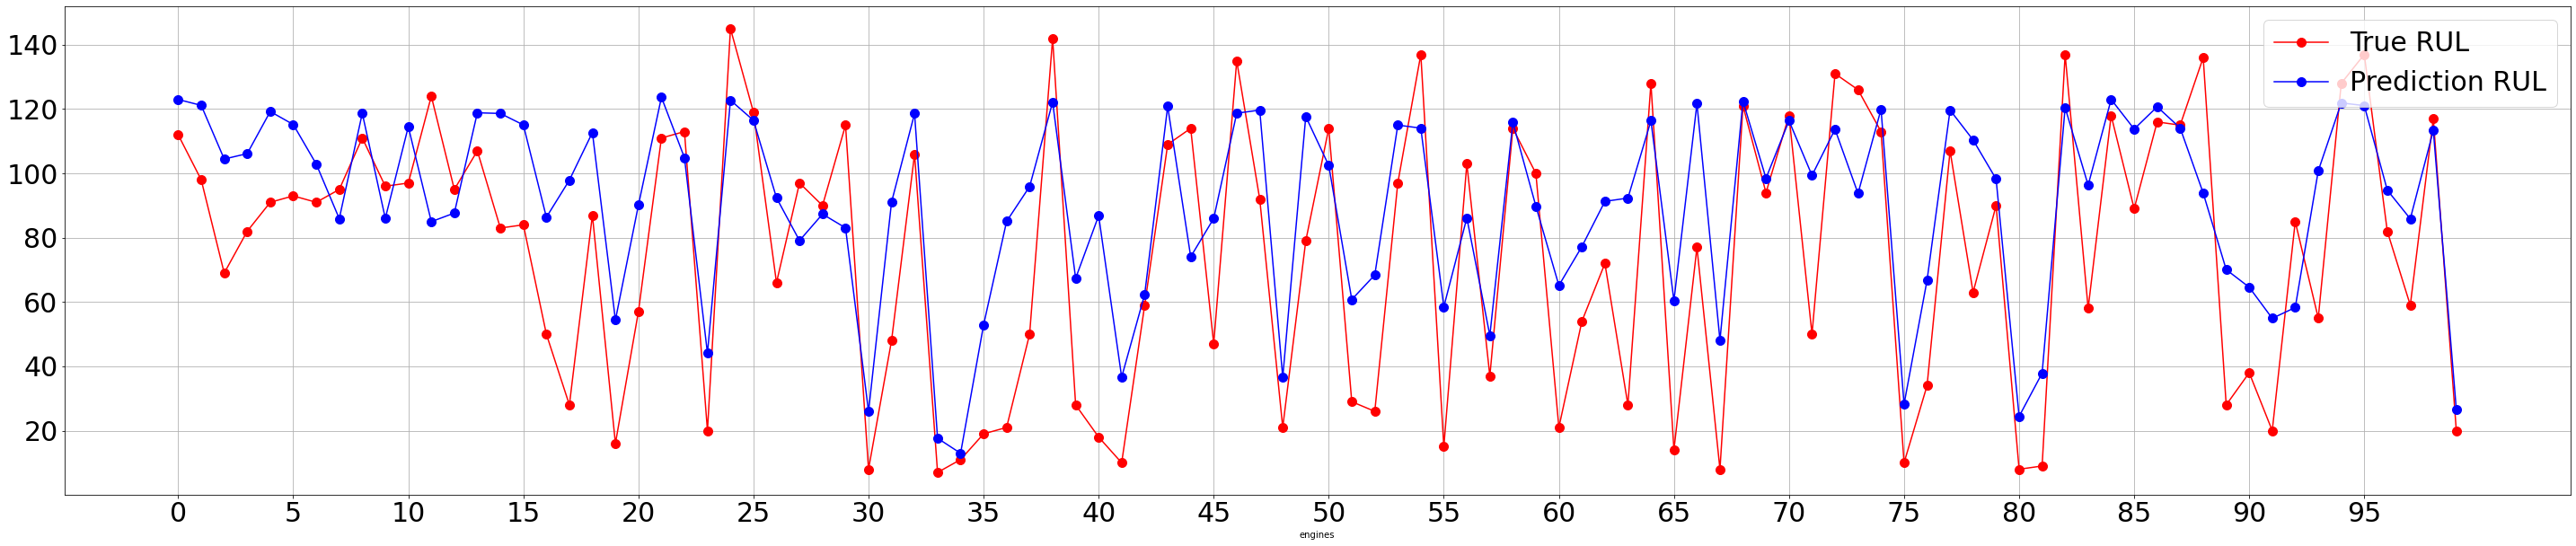

In [74]:
# Plot true and predicted RUL values
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(true_rul, label = "True RUL", color = "red",marker = 'o',markersize = 10)
ax.plot(rul_pred, label = "Prediction RUL", color = "blue",marker = 'o',markersize = 10)
ax.legend(loc=1,fontsize=30)
ax.grid()
ax.set_xlabel('engines')
ax.set_xticks(np.arange(0, len(true_rul), step=5))
ax.tick_params(axis='both', which='major', labelsize=30)

plt.show()


For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, $d_i = y^{\text{predicted}}_i - y^{\text{true}}_i$ for any datapoint $i$ and 

$$
\begin{equation}
    s_i=
    \begin{cases}
      \left(e^{-\frac{d_i}{13}} \right)-1, & \text{for}\ d_i \le 0 \\
      \left((e^{\frac{d_i}{10}} \right)-1, & \text{for}\ d_i > 0\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [75]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff <= 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [76]:
s_score = compute_s_score(true_rul, rul_pred)
print("S-score: ", s_score)

S-score:  34106005.23337829


## Homework: Tuning hyperparameters of gradient boosting

In [53]:
param_grid = [(max_depth, eta) for max_depth in [5,10] for eta in np.array([0.01, 0.1,1])]
min_rmse = np.inf
best_params = None
params = dict()
params["objective"] = "reg:squarederror"
num_rounds = 300
for max_depth, eta in param_grid:
    print("max_depth: {}, eta: {}".format(max_depth, eta))
    
    params["max_depth"] = max_depth
    params["eta"] = eta
    
    cv_res = xgb.cv(params, dtrain, num_boost_round= num_rounds, early_stopping_rounds= 10, seed = 89)
    
    best_rmse_val = cv_res["test-rmse-mean"].min()
    best_num_rounds = cv_res["test-rmse-mean"].argmin() + 1
    
    print("RMSE: {} in {} rounds".format(best_rmse_val, best_num_rounds))
    print()
    
    if best_rmse_val < min_rmse:
        min_rmse = best_rmse_val
        best_params = (max_depth, eta, best_num_rounds)
        
print("Best parameters are: Max_depth= {}, eta= {}, num_rounds = {}. Corresponding RMSE: {}".format(best_params[0],
                                                                                                    best_params[1],
                                                                                                    best_params[2],
                                                                                                    min_rmse))

max_depth: 5, eta: 0.01
RMSE: 8.616185912150923 in 300 rounds

max_depth: 5, eta: 0.1
RMSE: 4.487699944225846 in 299 rounds

max_depth: 5, eta: 1.0
RMSE: 7.234910402931386 in 45 rounds

max_depth: 10, eta: 0.01
RMSE: 8.01069960276083 in 300 rounds

max_depth: 10, eta: 0.1
RMSE: 5.140074346799394 in 300 rounds

max_depth: 10, eta: 1.0
RMSE: 8.350242946914301 in 4 rounds

Best parameters are: Max_depth= 5, eta= 0.1, num_rounds = 299. Corresponding RMSE: 4.487699944225846


We will use the best model to predict on test set.

In [54]:
params_tuned = {"max_depth":5, "eta":0.1, "objective":"reg:squarederror"}
bst_tuned = xgb.train(params_tuned, dtrain, num_boost_round= 300)


rul_pred_tuned = bst_tuned.predict(dtest)

RMSE_tuned = np.sqrt(mean_squared_error(true_rul, rul_pred_tuned))
print("RMSE after hyperparameter tuning: ", RMSE_tuned)

RMSE after hyperparameter tuning:  28.35750091548794


## Homework. Changing the learning window

**HomeWork**

Prepare the data with window_length = k and shift = 1.

In this case, for the x_train, we have a certain number of batches, each batch contains k rows. The two consecutive batches with have k-1 overlapping rows (because we set shift =1). For y_train, for each batch, we should use the RUL corresponding to the last row in the batch. Similarly, for the y_train and y_test.

At the end, one would expect to have:
- x_train shape:  (20231, k, 18) , i.e., 20231 batches, each batch is a matrix of k * 18 (i.e., a batch has k row, each row has 18 columns/ features)

- y_train shape: (20231,)

- x_test shape:  (k * 100, k, 18)

- y_test shape: (100,)


**Note 1**: Theoretically, to have a better evaluation, we should test with several batches of the test set and take the average performance. Beware that the \\RUL_FD001.txt file only contains the y_values of the last row of each engines. If one want to test with an arbitrary batch in the test set, one need to re-compute the corresponding RUL.)



**Remark:** if one change shift to something other than 1, the number of batches (i.e., the first number in the tuples representing the shapes above) can be computed as:

num_batches_input = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
num_batches_output = np.int(np.floor((len(ouput_data) - window_length)/shift)) + 1



### Extra_homework: 
We can also try a hybrid version (i.e., a Random Boosted Forest algorithm) by setting the parameter ```num_parallel_tree``` in xgb.train to a number that is larger than 1.

num_parallel_tree, [default=1]
Number of parallel trees constructed during each iteration. This option is used to support boosted random forest.